In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy import integrate

# By using trange instead of range, we get a nice progress bar
from tqdm import trange

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

from scipy.interpolate import interp1d

from scipy.integrate import quad

In [2]:
#used the thomas algorithm, taken from another course


# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

In [3]:
def diffusion(theta,Nx,Nt,tmax,t0=0,g0=0,g1=0,xmax=1,xmin=0):
    Nt = np.int(Nt)
    Nx = np.int(Nx)
    h = (xmax-xmin)/(Nx-1)
    X = np.linspace(xmin,xmax,Nx)

    #letting the first and last value also be a part of the interval
    k = (tmax-t0)/(Nt-2)
    T=np.linspace(t0,tmax,Nt)

    #creating a matrix for taking in the different values
    Us = np.zeros((Nt,Nx))

    r = k/(h**2)

    sub = np.zeros(Nx-3)
    main = np.zeros(Nx-2)

    sub.fill(r)
    main.fill(r)

    R  = diags(diagonals = [sub*(1-theta), 1 - main*2*(1-theta), sub*(1-theta)], offsets = [1, 0, -1],format='csc')
    L  = diags(diagonals = [-sub*theta, 1 + main*2*theta, -sub*theta], offsets = [1, 0, -1], format = 'csc')

    #initialising T
    #we already know the function to initialize with
    Us[0] = np.sin(np.pi*X)

    for t in trange (Nt-1):
        rhs = R.dot(Us[t,1:-1]) 
        Us[t+1,1:-1] = tdma(L,rhs)
        #Us[t+1,1:-1] = spsolve(L,rhs)
        Us[t+1,0] = r*theta*g0
        Us[t+1,-1] = r*theta*g1
    return Us, X, T

In [4]:
def u_analyt(x,t):
    return np.sin(np.pi*x)*np.exp(-t*np.pi**(2))

In [5]:
#i would actually like to make a function for the UMR but am afraid there will be too many function calls
def UMR(direction,tol,theta,Nx,Nt,tmax,t0=0,g0=0,g1=0,xmax=1,xmin=0):
    err_l2 = np.zeros(20)
    err_L2 = np.zeros(20)
    step_lst_Nt = np.zeros(20)
    step_lst_Nx = np.zeros(20)
    if direction=='x':
        Nt=1e5
        Us, x, t = diffusion(theta,Nx,Nt,tmax)
        #X,T = np.meshgrid(x,t)
        """err_l2[0] = np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))
        step_lst[0] = Nx*Nt
        u_interp = interp1d(x,Us[-1,:],kind = 'cubic')
        xs = np.linspace(0,1,np.int(1e6))
        err_L2[0] = np.linalg.norm(u_analyt(xs,t[-1])-u_interp(xs))/np.linalg.norm(u_analyt(xs,t[-1]))"""
        for i in range(tol):
            #halfing the stepsize
            Nx=Nx*2
            #running a new diffusion equation simulation
            Us, x, t = diffusion(theta,Nx,Nt,tmax)
            u_interp = interp1d(x,Us[-1,:],kind = 'cubic')            
            
            plt.figure(figsize=(3,2))
            plt.plot(x,Us[-1,:],label="num")
            plt.plot(x,u_analyt(x,t[-1]),"--",label="anal")
            xs = np.linspace(0,1,np.int(1e6))
            plt.plot(xs,u_interp(xs),"--",label="interpolated")
            plt.legend()
            plt.show()
            #X, T = np.meshgrid(x,t)
            print("Iteration nr: ",i, ", UMR for direction: ", direction)
            print("Error: ",(np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))))
            err_l2[i+1] = np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))
            
            diff = lambda x: (u_interp(x) - u_analyt(x,t[-1]))**2
            lower = lambda x: u_analyt(x,t[-1])**2
            
            print(np.sqrt(quad(diff,xmin,xmax)[0]))
            print(np.sqrt(quad(diff,xmin,xmax)[0]))
            err_L2[i+1] = np.sqrt(quad(diff,xmin,xmax)[0])/np.sqrt(quad(lower,xmin,xmax)[0])

            
            #err_L2[i+1] = np.linalg.norm(u_analyt(xs,t[-1])-u_interp(xs))/np.linalg.norm(u_analyt(xs,t[-1]))
            step_lst_Nt[i+1] = Nt
            step_lst_Nx[i+1] = Nx
        return err_l2[err_l2 != 0], err_L2[err_L2 != 0], step_lst_Nt[step_lst_Nt != 0],step_lst_Nx[step_lst_Nx != 0]
    elif direction=='t':
        Nx=1e5
        Us, x, t = diffusion(theta,Nx,Nt,tmax)
        """err_l2[0] = np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))
        step_lst[0] = Nx*Nt
        u_interp = interp1d(x,Us[-1,:],kind = 'cubic')
        xs = np.linspace(0,1,np.int(1e6))
        err_L2[0] = np.linalg.norm(u_analyt(xs,t[-1])-u_interp(xs))/np.linalg.norm(u_analyt(xs,t[-1]))"""
        for i in range(tol):
            #halfing the stepsize
            Nt=Nt*2
            #running a new diffusion equation simulation
            Us, x, t = diffusion(theta,Nx,Nt,tmax)
            u_interp = interp1d(x,Us[-1,:],kind = 'cubic')
            plt.figure(figsize=(3,2))
            plt.plot(x,Us[-1,:],label="num")
            plt.plot(x,u_analyt(x,t[-1]),"--",label="anal")
            xs = np.linspace(0,1,np.int(1e6))
            plt.plot(xs,u_interp(xs),"--",label="interpolated")
            plt.legend()
            plt.show()
            #X, T = np.meshgrid(x,t)
            print("Iteration nr: ",i, ", UMR for direction: ", direction)
            print("Error: ",(np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))))
            print("E ",(np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])))
            err_l2[i+1] = np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))
            #err_L2[i+1] = np.linalg.norm(u_analyt(xs,t[-1])-u_interp(xs))/np.linalg.norm(u_analyt(xs,t[-1]))
            
            diff = lambda x: (u_interp(x) - u_analyt(x,t[-1]))**2
            lower = lambda x: u_analyt(x,t[-1])**2
            err_L2[i+1] = np.sqrt(quad(diff,xmin,xmax)[0])/np.sqrt(quad(lower,xmin,xmax)[0])
            
            step_lst_Nt[i+1] = Nt
            step_lst_Nx[i+1] = Nx
        return err_l2[err_l2 != 0],err_L2[err_L2 != 0], step_lst_Nt[step_lst_Nt != 0],step_lst_Nx[step_lst_Nx != 0]
    elif direction=='r':
        Us, x, t = diffusion(theta,Nx,Nt,tmax)
        #X, T = np.meshgrid(x,t)
        """err_l2[0] = np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))
        step_lst[0] = Nx*Nt
        u_interp = interp1d(x,Us[-1,:],kind = 'cubic')
        xs = np.linspace(0,1,np.int(1e6))
        err_L2[0] = np.linalg.norm(u_analyt(xs,t[-1])-u_interp(xs))/np.linalg.norm(u_analyt(xs,t[-1]))"""
        for i in range(tol):
            #halfing the stepsize
            Nx=Nx*2
            Nt=Nt*4
            #running a new diffusion equation simulation
            Us, x, t = diffusion(theta,Nx,Nt,tmax)
            u_interp = interp1d(x,Us[-1,:],kind = 'cubic')
            plt.figure(figsize=(3,2))
            plt.plot(x,Us[-1,:],label="num")
            plt.plot(x,u_analyt(x,t[-1]),"--",label="anal")
            xs = np.linspace(0,1,np.int(1e6))
            plt.plot(xs,u_interp(xs),"--",label="interpolated")
            plt.legend()
            plt.show()
            #X, T = np.meshgrid(x,t)
            print("Iteration nr: ",i, ", UMR for direction: ", direction)
            print("Error: ",(np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))))
            print("E ",(np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])))
            err_l2[i+1] = np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))
            #err_L2[i+1] = np.linalg.norm(u_analyt(xs,t[-1])-u_interp(xs))/np.linalg.norm(u_analyt(xs,t[-1]))
            
            diff = lambda x: (u_interp(x) - u_analyt(x,t[-1]))**2
            lower = lambda x: u_analyt(x,t[-1])**2
            err_L2[i+1] = np.sqrt(quad(diff,xmin,xmax)[0])/np.sqrt(quad(lower,xmin,xmax)[0])
            
            step_lst_Nt[i+1] = Nt
            step_lst_Nx[i+1] = Nx
        return err_l2[err_l2 != 0], err_L2[err_L2 != 0], step_lst_Nt[step_lst_Nt != 0],step_lst_Nx[step_lst_Nx != 0]
    elif direction=='c':
        Us, x, t = diffusion(theta,Nx,Nt,tmax)
        #X, T = np.meshgrid(x,t)
        """err_l2[0] = np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))
        step_lst[0] = Nx*Nt
        u_interp = interp1d(x,Us[-1,:],kind = 'cubic')
        xs = np.linspace(0,1,np.int(1e6))
        err_L2[0] = np.linalg.norm(u_analyt(xs,t[-1])-u_interp(xs))/np.linalg.norm(u_analyt(xs,t[-1]))"""
        for i in range(tol):
            #halfing the stepsize
            Nx=Nx*2
            Nt=Nt*2
            #running a new diffusion equation simulation
            Us, x, t = diffusion(theta,Nx,Nt,tmax)
            u_interp = interp1d(x,Us[-1,:],kind = 'cubic')
            plt.figure(figsize=(3,2))
            plt.plot(x,Us[-1,:],label="num")
            plt.plot(x,u_analyt(x,t[-1]),"--",label="anal")
            xs = np.linspace(0,1,np.int(1e6))
            plt.plot(xs,u_interp(xs),"--",label="interpolated")
            plt.legend()
            plt.show()
            #X, T = np.meshgrid(x,t)
            print("Iteration nr: ",i, ", UMR for direction: ", direction)
            print("Error: ",(np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))))
            err_l2[i+1] = np.linalg.norm(u_analyt(x,t[-1])-Us[-1,:])/np.linalg.norm(u_analyt(x,t[-1]))
            #err_L2[i+2] = np.linalg.norm(u_analyt(xs,t[-1])-u_interp(xs))/np.linalg.norm(u_analyt(xs,t[-1]))
            
            diff = lambda x: (u_interp(x) - u_analyt(x,t[-1]))**2
            lower = lambda x: u_analyt(x,t[-1])**2
            err_L2[i+1] = np.sqrt(quad(diff,xmin,xmax)[0])/np.sqrt(quad(lower,xmin,xmax)[0])
            
            step_lst_Nt[i+1] = Nt
            step_lst_Nx[i+1] = Nx
        return err_l2[err_l2 != 0], err_L2[err_L2 != 0], step_lst_Nt[step_lst_Nt != 0],step_lst_Nx[step_lst_Nx != 0]
    return err_l2[err_l2 != 0], err_L2[err_L2 != 0], step_lst_Nt[step_lst_Nt != 0],step_lst_Nx[step_lst_Nx != 0]

In [6]:
Nx=10
Nt=223
tmax = 1
theta_CN = 0.5
#trying theta=0
theta_BE = 0

U_CN, X_CN, T_CN = diffusion(theta_CN,Nx,Nt,tmax,t0=0,g0=0,g1=0,xmax=1,xmin=0)
U_BE, X_BE, T_BE = diffusion(theta_BE,Nx,Nt,tmax,t0=0,g0=0,g1=0,xmax=1,xmin=0)


100%|██████████| 222/222 [00:00<00:00, 17122.13it/s]


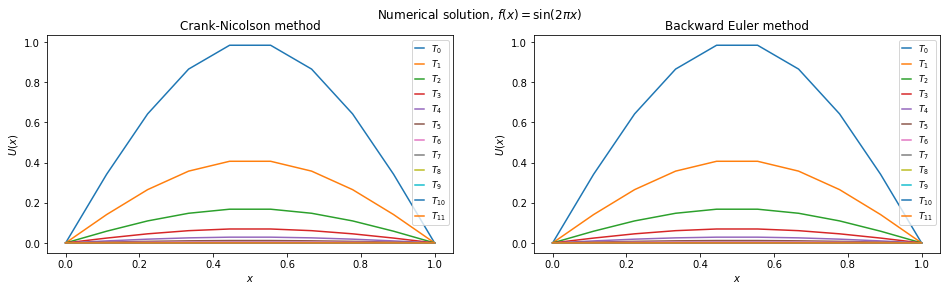

In [7]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.title("Crank-Nicolson method")
for i in range(0,len(T_CN),20):
    plt.plot(X_CN, U_CN[i,:],label="$T_{"+str(int(i/20))+"}$")
    plt.xlabel("$x$")
    plt.ylabel("$U(x)$")
    plt.legend(loc = 'upper right',prop={'size':9},borderpad = 0.3,labelspacing = 0.3,handlelength = 1)
    
plt.subplot(1,2,2)
plt.title("Backward Euler method")
for i in range(0,len(T_CN),20):
    plt.plot(X_CN, U_CN[i,:],label="$T_{"+str(int(i/20))+"}$")
    plt.xlabel("$x$")
    plt.ylabel("$U(x)$")
    plt.legend(loc = 'upper right',prop={'size':9},borderpad = 0.3,labelspacing = 0.3,handlelength = 1)
    
#plt.tight_layout()
plt.suptitle("Numerical solution, $f(x)=\sin(2 \pi x)$")
plt.savefig('2bsol.png')
plt.show()

100%|██████████| 99999/99999 [00:02<00:00, 37103.88it/s]


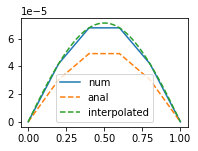

  8%|▊         | 7521/99999 [00:00<00:02, 37434.77it/s]

Iteration nr:  0 , UMR for direction:  x
Error:  0.37762171731545335
1.380789231552043e-05
1.380789231552043e-05


100%|██████████| 99999/99999 [00:02<00:00, 38697.92it/s]


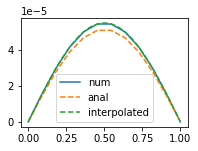

  9%|▉         | 8800/99999 [00:00<00:02, 43816.80it/s]

Iteration nr:  1 , UMR for direction:  x
Error:  0.06908803251259267
2.5264536240065825e-06
2.5264536240065825e-06


100%|██████████| 99999/99999 [00:02<00:00, 39976.25it/s]


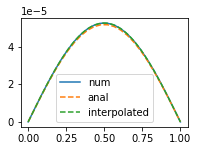

  4%|▍         | 4192/99999 [00:00<00:02, 41616.32it/s]

Iteration nr:  2 , UMR for direction:  x
Error:  0.015353426061541421
5.615153356220495e-07
5.615153356220495e-07


100%|██████████| 99999/99999 [00:02<00:00, 40338.99it/s]


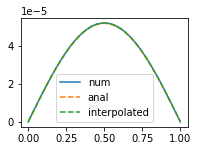

  6%|▋         | 6384/99999 [00:00<00:02, 31712.17it/s]

Iteration nr:  3 , UMR for direction:  x
Error:  0.0035818886049386795
1.3100215822694492e-07
1.3100215822694492e-07


100%|██████████| 99999/99999 [00:03<00:00, 32095.14it/s]


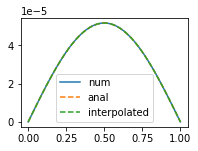

  3%|▎         | 2575/99999 [00:00<00:03, 25068.32it/s]

Iteration nr:  4 , UMR for direction:  x
Error:  0.0008010284118972994
2.9296578318176576e-08
2.9296578318176576e-08


100%|██████████| 99999/99999 [00:03<00:00, 28218.26it/s]


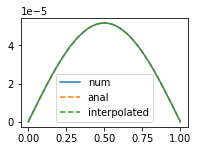

100%|██████████| 19/19 [00:00<00:00, 129.57it/s]

Iteration nr:  5 , UMR for direction:  x
Error:  0.00012381285590127835
4.528303925430118e-09
4.528303925430118e-09



100%|██████████| 39/39 [00:00<00:00, 133.48it/s]


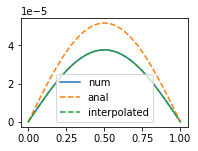

 16%|█▋        | 13/79 [00:00<00:00, 124.14it/s]

Iteration nr:  0 , UMR for direction:  t
Error:  0.2718524121108059
E  0.0031441357703588958


100%|██████████| 79/79 [00:00<00:00, 120.38it/s]


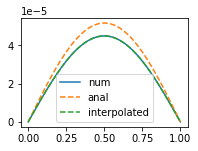

  9%|▉         | 15/159 [00:00<00:01, 140.56it/s]

Iteration nr:  1 , UMR for direction:  t
Error:  0.1305571116930188
E  0.0015099710970430838


100%|██████████| 159/159 [00:01<00:00, 136.84it/s]


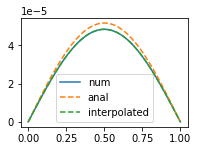

  4%|▍         | 13/319 [00:00<00:02, 129.06it/s]

Iteration nr:  2 , UMR for direction:  t
Error:  0.06358590318298361
E  0.0007354090079094412


100%|██████████| 319/319 [00:02<00:00, 137.22it/s]


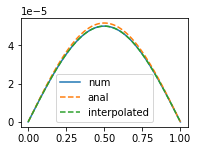

  2%|▏         | 15/639 [00:00<00:04, 146.02it/s]

Iteration nr:  3 , UMR for direction:  t
Error:  0.03133041288823778
E  0.00036235496715721874


100%|██████████| 639/639 [00:05<00:00, 109.83it/s]


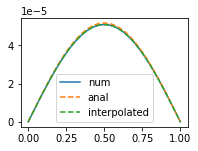

  1%|          | 10/1279 [00:00<00:12, 98.30it/s]

Iteration nr:  4 , UMR for direction:  t
Error:  0.015545114980062683
E  0.00017978855395712053


100%|██████████| 1279/1279 [00:09<00:00, 137.47it/s]


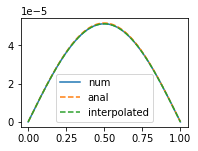

100%|██████████| 79/79 [00:00<00:00, 15846.49it/s]

Iteration nr:  5 , UMR for direction:  t
Error:  0.007742160894620647
E  8.954272216914796e-05


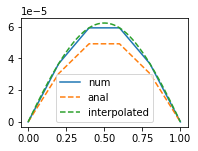

100%|██████████| 319/319 [00:00<00:00, 39991.12it/s]

Iteration nr:  0 , UMR for direction:  r
Error:  0.20432854062024391
E  1.6710302334253872e-05


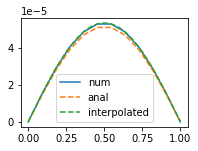

100%|██████████| 1279/1279 [00:00<00:00, 37719.57it/s]

Iteration nr:  1 , UMR for direction:  r
Error:  0.035929521156558064
E  4.358309260778343e-06


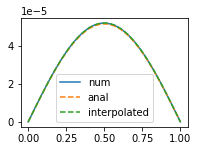

100%|██████████| 5119/5119 [00:00<00:00, 40088.43it/s]

Iteration nr:  2 , UMR for direction:  r
Error:  0.007604518133221455
E  1.3338466120920925e-06


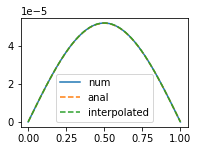

 18%|█▊        | 3732/20479 [00:00<00:00, 37038.16it/s]

Iteration nr:  3 , UMR for direction:  r
Error:  0.0017449305506615372
E  4.3751943307333264e-07


100%|██████████| 20479/20479 [00:00<00:00, 37129.66it/s]


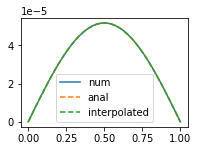

  7%|▋         | 5942/81919 [00:00<00:02, 29617.33it/s]

Iteration nr:  4 , UMR for direction:  r
Error:  0.0004173834509893591
E  1.487877925062242e-07


100%|██████████| 81919/81919 [00:02<00:00, 30477.85it/s]


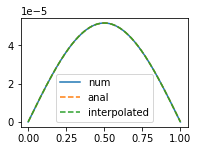

100%|██████████| 39/39 [00:00<00:00, 19552.70it/s]

Iteration nr:  5 , UMR for direction:  r
Error:  0.00010202346150697639
E  5.15687981845636e-08


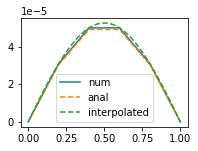

100%|██████████| 79/79 [00:00<00:00, 38614.38it/s]

Iteration nr:  0 , UMR for direction:  c
Error:  0.017240001180625884


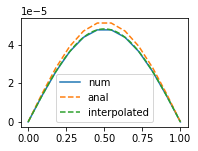

100%|██████████| 159/159 [00:00<00:00, 39859.80it/s]

Iteration nr:  1 , UMR for direction:  c
Error:  0.06934848022781953


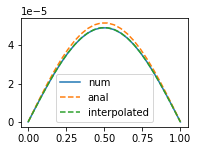

100%|██████████| 319/319 [00:00<00:00, 40044.98it/s]

Iteration nr:  2 , UMR for direction:  c
Error:  0.049008252313351416


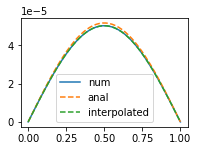

100%|██████████| 639/639 [00:00<00:00, 35680.28it/s]

Iteration nr:  3 , UMR for direction:  c
Error:  0.027752377378073723


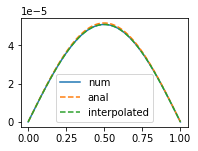

100%|██████████| 1279/1279 [00:00<00:00, 26154.33it/s]

Iteration nr:  4 , UMR for direction:  c
Error:  0.014657389024753472


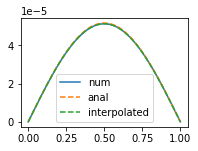

 11%|█         | 11108/99999 [00:00<00:01, 55116.30it/s]

Iteration nr:  5 , UMR for direction:  c
Error:  0.007520676604680552


100%|██████████| 99999/99999 [00:02<00:00, 42111.04it/s]


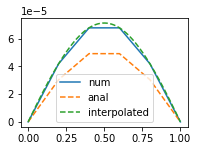

  9%|▉         | 9177/99999 [00:00<00:01, 45612.76it/s]

Iteration nr:  0 , UMR for direction:  x
Error:  0.3782499503108537
1.3830867367929404e-05
1.3830867367929404e-05


100%|██████████| 99999/99999 [00:02<00:00, 41363.99it/s]


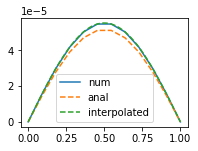

  3%|▎         | 3231/99999 [00:00<00:03, 32075.41it/s]

Iteration nr:  1 , UMR for direction:  x
Error:  0.06960180518738708
2.5452440771173402e-06
2.5452440771173402e-06


100%|██████████| 99999/99999 [00:02<00:00, 39493.30it/s]


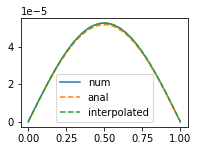

  4%|▍         | 3886/99999 [00:00<00:02, 38577.67it/s]

Iteration nr:  2 , UMR for direction:  x
Error:  0.01584652392710876
5.795497973121307e-07
5.795497973121307e-07


100%|██████████| 99999/99999 [00:02<00:00, 37025.00it/s]


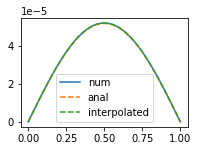

  7%|▋         | 7435/99999 [00:00<00:02, 36993.26it/s]

Iteration nr:  3 , UMR for direction:  x
Error:  0.004070424161521739
1.4886976706830014e-07
1.4886976706830014e-07


100%|██████████| 99999/99999 [00:03<00:00, 30091.87it/s]


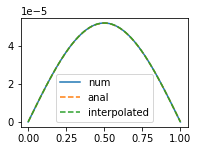

  2%|▏         | 1542/99999 [00:00<00:06, 15306.08it/s]

Iteration nr:  4 , UMR for direction:  x
Error:  0.00128848441417846
4.712470426951106e-08
4.712470426951106e-08


100%|██████████| 99999/99999 [00:04<00:00, 23579.55it/s]


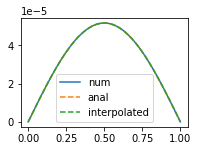

 53%|█████▎    | 10/19 [00:00<00:00, 90.32it/s]

Iteration nr:  5 , UMR for direction:  x
Error:  0.0006110058608091125
2.234681109952024e-08
2.234681109952024e-08


100%|██████████| 39/39 [00:00<00:00, 104.28it/s]


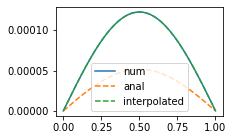

 18%|█▊        | 14/79 [00:00<00:00, 134.97it/s]

Iteration nr:  0 , UMR for direction:  t
Error:  1.374331196299268
E  0.015894962421166253


100%|██████████| 79/79 [00:00<00:00, 147.77it/s]


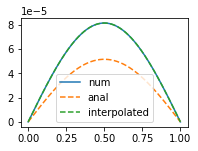

 11%|█         | 17/159 [00:00<00:00, 160.81it/s]

Iteration nr:  1 , UMR for direction:  t
Error:  0.5795497902507551
E  0.00670284001559155


100%|██████████| 159/159 [00:01<00:00, 157.07it/s]


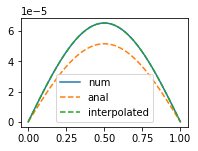

  4%|▍         | 12/319 [00:00<00:02, 119.16it/s]

Iteration nr:  2 , UMR for direction:  t
Error:  0.26541472587318793
E  0.003069680077945206


100%|██████████| 319/319 [00:02<00:00, 139.73it/s]


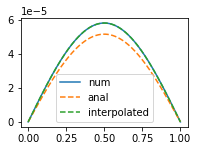

  2%|▏         | 15/639 [00:00<00:04, 143.24it/s]

Iteration nr:  3 , UMR for direction:  t
Error:  0.12692982272231706
E  0.0014680193302235081


100%|██████████| 639/639 [00:04<00:00, 157.91it/s]


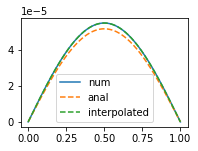

  0%|          | 0/1279 [00:00<?, ?it/s]

Iteration nr:  4 , UMR for direction:  t
Error:  0.06205877026296853
E  0.0007177468021462826


100%|██████████| 1279/1279 [00:07<00:00, 162.98it/s]


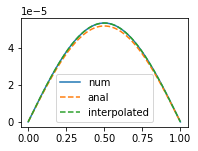

100%|██████████| 79/79 [00:00<00:00, 15839.67it/s]

Iteration nr:  5 , UMR for direction:  t
Error:  0.03068226555876343
E  0.00035485875556490713


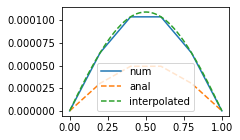

100%|██████████| 319/319 [00:00<00:00, 35543.06it/s]

Iteration nr:  0 , UMR for direction:  r
Error:  1.1080720511896651
E  9.061983669686933e-05


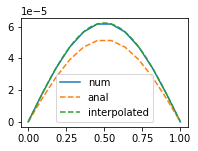

100%|██████████| 1279/1279 [00:00<00:00, 40032.80it/s]

Iteration nr:  1 , UMR for direction:  r
Error:  0.2027349328386569
E  2.4592076566339583e-05


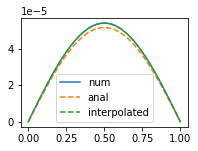

100%|██████████| 5119/5119 [00:00<00:00, 36388.45it/s]

Iteration nr:  2 , UMR for direction:  r
Error:  0.04650040539128468
E  8.156257517634313e-06


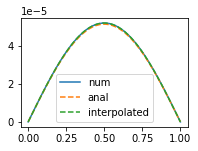

 35%|███▍      | 7111/20479 [00:00<00:00, 35392.98it/s]

Iteration nr:  3 , UMR for direction:  r
Error:  0.01130882495034625
E  2.8355459070421064e-06


100%|██████████| 20479/20479 [00:00<00:00, 36214.76it/s]


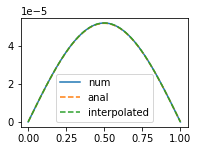

  4%|▍         | 3111/81919 [00:00<00:02, 30581.20it/s]

Iteration nr:  4 , UMR for direction:  r
Error:  0.002798699264467287
E  9.976732054465118e-07


100%|██████████| 81919/81919 [00:02<00:00, 29104.75it/s]


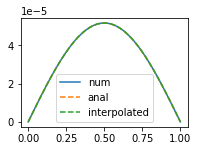

100%|██████████| 39/39 [00:00<00:00, 39114.74it/s]

Iteration nr:  5 , UMR for direction:  r
Error:  0.0006967579464099714
E  3.5218340361299963e-07


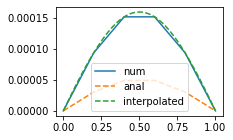

100%|██████████| 79/79 [00:00<00:00, 26168.85it/s]

Iteration nr:  0 , UMR for direction:  c
Error:  2.0853706505441347


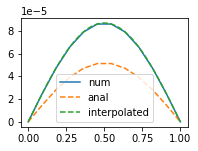

100%|██████████| 159/159 [00:00<00:00, 31651.37it/s]

Iteration nr:  1 , UMR for direction:  c
Error:  0.6775148875129089


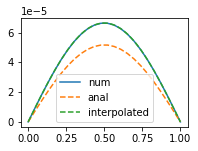

100%|██████████| 319/319 [00:00<00:00, 28990.16it/s]

Iteration nr:  2 , UMR for direction:  c
Error:  0.28392998661764685


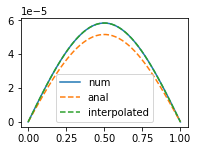

100%|██████████| 639/639 [00:00<00:00, 33660.21it/s]

Iteration nr:  3 , UMR for direction:  c
Error:  0.13096596411316172


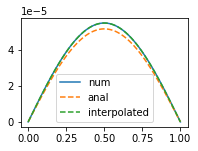

100%|██████████| 1279/1279 [00:00<00:00, 31250.09it/s]

Iteration nr:  4 , UMR for direction:  c
Error:  0.0630020943177233


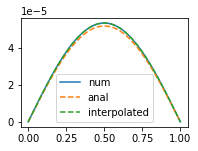

Iteration nr:  5 , UMR for direction:  c
Error:  0.030910965093871604


In [8]:
Nx=3
Nt=20
tmax = 1
theta_CN = 0.5
theta_BE = 1
tol=6


x_CN_l2, x_CN_L2, x_CN_stepNt,x_CN_stepNx = UMR('x',tol,theta_CN,Nx,Nt,tmax)
t_CN_l2, t_CN_L2, t_CN_stepNt,t_CN_stepNx = UMR('t',tol,theta_CN,Nx,Nt,tmax)
r_CN_l2, r_CN_L2, r_CN_stepNt,r_CN_stepNx = UMR('r',tol,theta_CN,Nx,Nt,tmax)
c_CN_l2, c_CN_L2, c_CN_stepNt,c_CN_stepNx = UMR('c',tol,theta_CN,Nx,Nt,tmax)
x_BE_l2, x_BE_L2, x_BE_stepNt,x_BE_stepNx = UMR('x',tol,theta_BE,Nx,Nt,tmax)
t_BE_l2, t_BE_L2, t_BE_stepNt,t_BE_stepNx = UMR('t',tol,theta_BE,Nx,Nt,tmax)
r_BE_l2, r_BE_L2, r_BE_stepNt,r_BE_stepNx = UMR('r',tol,theta_BE,Nx,Nt,tmax)
c_BE_l2, c_BE_L2, c_BE_stepNt,c_BE_stepNx = UMR('c',tol,theta_BE,Nx,Nt,tmax)

100%|██████████| 1999/1999 [00:00<00:00, 31815.30it/s]


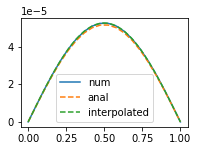

100%|██████████| 3999/3999 [00:00<00:00, 33971.09it/s]

Iteration nr:  0 , UMR for direction:  c
Error:  0.0176713402363399


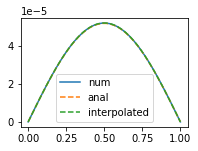

 50%|████▉     | 3977/7999 [00:00<00:00, 39482.18it/s]

Iteration nr:  1 , UMR for direction:  c
Error:  0.002867542721958969


100%|██████████| 7999/7999 [00:00<00:00, 39053.73it/s]


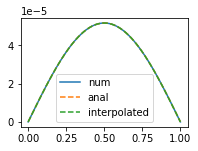

 21%|██▏       | 3427/15999 [00:00<00:00, 34021.90it/s]

Iteration nr:  2 , UMR for direction:  c
Error:  6.549588186072616e-05


100%|██████████| 15999/15999 [00:00<00:00, 32407.71it/s]


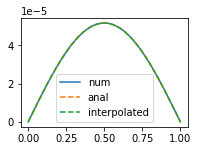

 15%|█▌        | 4870/31999 [00:00<00:01, 23604.37it/s]

Iteration nr:  3 , UMR for direction:  c
Error:  0.00029609273132961755


100%|██████████| 31999/31999 [00:01<00:00, 23132.32it/s]


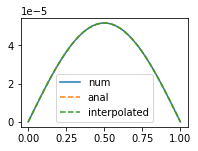

  3%|▎         | 1928/63999 [00:00<00:03, 19219.17it/s]

Iteration nr:  4 , UMR for direction:  c
Error:  0.00022872478304074623


100%|██████████| 63999/63999 [00:03<00:00, 18460.23it/s]


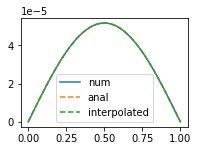

100%|██████████| 1999/1999 [00:00<00:00, 37117.41it/s]

Iteration nr:  5 , UMR for direction:  c
Error:  0.000134347650550738


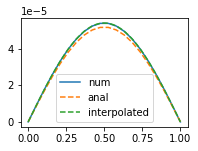

100%|██████████| 3999/3999 [00:00<00:00, 35473.08it/s]

Iteration nr:  0 , UMR for direction:  c
Error:  0.04261859828759431


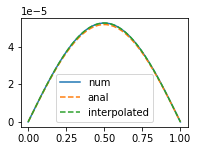

100%|██████████| 7999/7999 [00:00<00:00, 40102.41it/s]

Iteration nr:  1 , UMR for direction:  c
Error:  0.01513393845376993


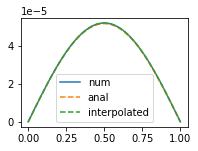

 13%|█▎        | 2039/15999 [00:00<00:00, 20242.15it/s]

Iteration nr:  2 , UMR for direction:  c
Error:  0.0061694421125526476


100%|██████████| 15999/15999 [00:00<00:00, 23836.26it/s]


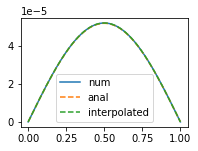

 13%|█▎        | 4174/31999 [00:00<00:01, 21240.88it/s]

Iteration nr:  3 , UMR for direction:  c
Error:  0.0027511091711950194


100%|██████████| 31999/31999 [00:01<00:00, 22096.80it/s]


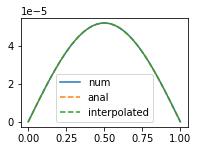

  3%|▎         | 1881/63999 [00:00<00:03, 18674.00it/s]

Iteration nr:  4 , UMR for direction:  c
Error:  0.0012939860045843193


100%|██████████| 63999/63999 [00:03<00:00, 17161.97it/s]


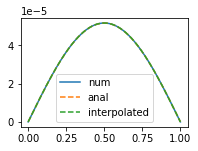

Iteration nr:  5 , UMR for direction:  c
Error:  0.0006268221233631709


In [9]:
Nx=10
Nt=1000
tmax = 1
theta_CN = 0.5
theta_BE = 1
tol=6

c_CN_l2, c_CN_L2, c_CN_stepNt,c_CN_stepNx = UMR('c',tol,theta_CN,Nx,Nt,tmax)
c_BE_l2, c_BE_L2, c_BE_stepNt,c_BE_stepNx = UMR('c',tol,theta_BE,Nx,Nt,tmax)

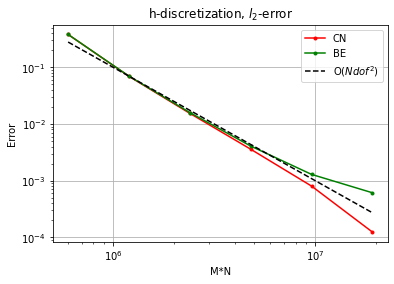

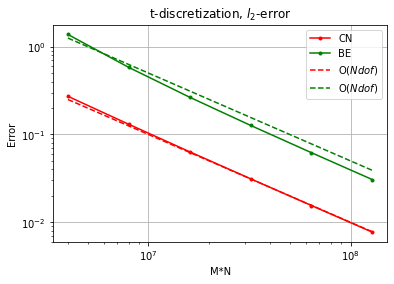

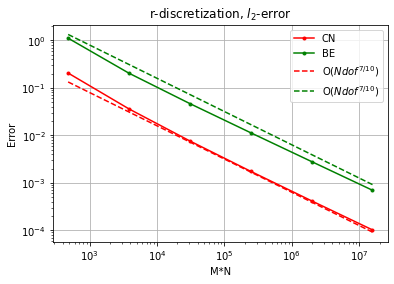

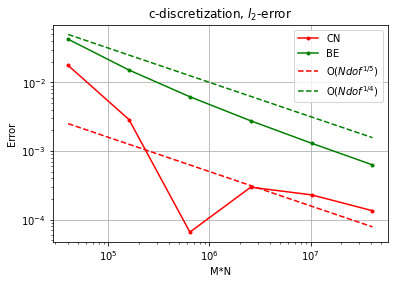

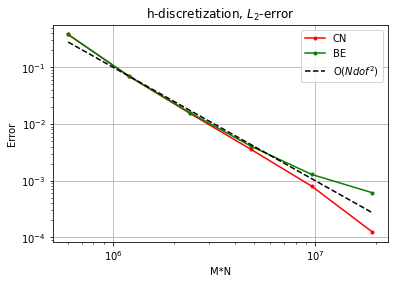

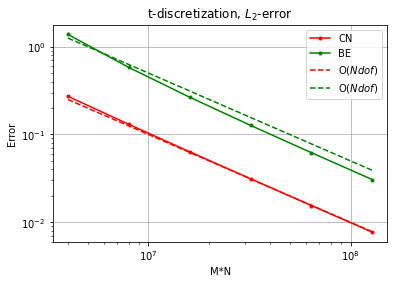

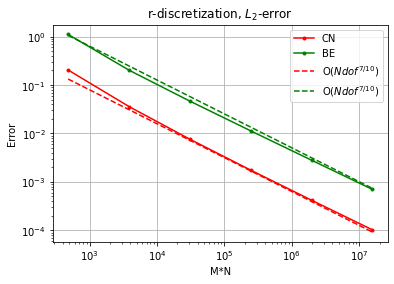

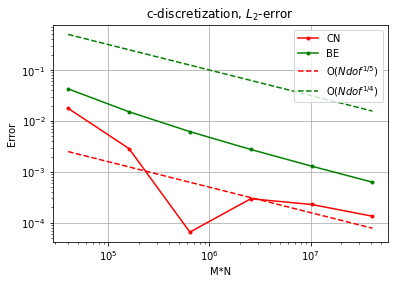

In [10]:
plt.title("h-discretization, $l_2$-error")
plt.loglog(x_CN_stepNt*x_CN_stepNx,x_CN_l2,".-r",label='CN')
plt.loglog(x_BE_stepNt*x_BE_stepNx,x_BE_l2,".-g",label='BE')
plt.loglog(x_CN_stepNt*x_CN_stepNx, 1e-9*(x_BE_stepNt * 1/x_BE_stepNx)**(2),"--k",label="O($Ndof^{2}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("t-discretization, $l_2$-error")
plt.loglog(t_CN_stepNt*t_CN_stepNx,t_CN_l2,".-r",label='CN')
plt.loglog(t_BE_stepNt*t_BE_stepNx,t_BE_l2,".-g",label='BE')
plt.loglog(t_CN_stepNt*t_CN_stepNx, 1e-4*(t_CN_stepNx * (1/t_CN_stepNt)),"--r",label="O($Ndof$)")
plt.loglog(t_BE_stepNt*t_BE_stepNx, (1/2000)*(t_BE_stepNx * (1/t_BE_stepNt)),"--g",label="O($Ndof$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("r-discretization, $l_2$-error")
plt.loglog(r_CN_stepNt*r_CN_stepNx,r_CN_l2,".-r",label='CN')
plt.loglog(r_BE_stepNt*r_BE_stepNx,r_BE_l2,".-g",label='BE')
plt.loglog(r_CN_stepNt*r_CN_stepNx, 1e+1*(1/r_CN_stepNx * 1/r_CN_stepNt)**(7/10),"--r",label="O($Ndof^{7/10}$)")
plt.loglog(r_BE_stepNt*r_BE_stepNx, 1e+2*(1/r_BE_stepNx * 1/r_BE_stepNt)**(7/10),"--g",label="O($Ndof^{7/10}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("c-discretization, $l_2$-error")
plt.loglog(c_CN_stepNt*c_CN_stepNx,c_CN_l2,".-r",label='CN')
plt.loglog(c_CN_stepNt*c_CN_stepNx,c_BE_l2,".-g",label='BE')
plt.loglog(c_CN_stepNt*c_CN_stepNx, 1/2*(1/c_CN_stepNt * (1/c_CN_stepNx))**(1/2),"--r",label="O($Ndof^{1/5}$)")
plt.loglog(c_BE_stepNt*c_BE_stepNx, 1e+1*(1/c_BE_stepNt * (1/c_BE_stepNx))**(1/2),"--g",label="O($Ndof^{1/4}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("h-discretization, $L_2$-error")
plt.loglog(x_CN_stepNt*x_CN_stepNx,x_CN_L2,".-r",label='CN')
plt.loglog(x_BE_stepNt*x_BE_stepNx,x_BE_L2,".-g",label='BE')
plt.loglog(x_BE_stepNt*x_BE_stepNx, 1e-9*(x_BE_stepNt * 1/x_BE_stepNx)**(2),"--k",label="O($Ndof^{2}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("t-discretization, $L_2$-error")
plt.loglog(t_CN_stepNt*t_CN_stepNx,t_CN_L2,".-r",label='CN')
plt.loglog(t_BE_stepNt*t_BE_stepNx,t_BE_L2,".-g",label='BE')
plt.loglog(t_CN_stepNt*t_CN_stepNx, 1e-4*(t_CN_stepNx * (1/t_CN_stepNt)),"--r",label="O($Ndof$)")
plt.loglog(t_BE_stepNt*t_BE_stepNx, (1/2000)*(t_BE_stepNx * (1/t_BE_stepNt)),"--g",label="O($Ndof$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("r-discretization, $L_2$-error")
plt.loglog(r_CN_stepNt*r_CN_stepNx,r_CN_L2,".-r",label='CN')
plt.loglog(r_BE_stepNt*r_BE_stepNx,r_BE_L2,".-g",label='BE')
plt.loglog(r_CN_stepNt*r_CN_stepNx, 1e+1*(1/r_CN_stepNx * 1/r_CN_stepNt)**(7/10),"--r",label="O($Ndof^{7/10}$)")
plt.loglog(r_BE_stepNt*r_BE_stepNx, 80*(1/r_BE_stepNx * 1/r_BE_stepNt)**(7/10),"--g",label="O($Ndof^{7/10}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("c-discretization, $L_2$-error")
plt.loglog(c_CN_stepNt*c_CN_stepNx,c_CN_L2,".-r",label='CN')
plt.loglog(c_BE_stepNt*c_BE_stepNx,c_BE_L2,".-g",label='BE')
plt.loglog(c_CN_stepNt*c_CN_stepNx, 1/2*(1/c_CN_stepNt * (1/c_CN_stepNx))**(1/2),"--r",label="O($Ndof^{1/5}$)")
plt.loglog(c_BE_stepNt*c_BE_stepNx, 1e+2*(1/c_BE_stepNt * (1/c_BE_stepNx))**(1/2),"--g",label="O($Ndof^{1/4}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

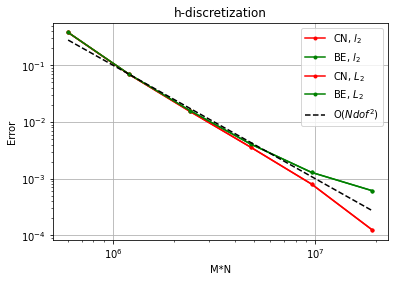

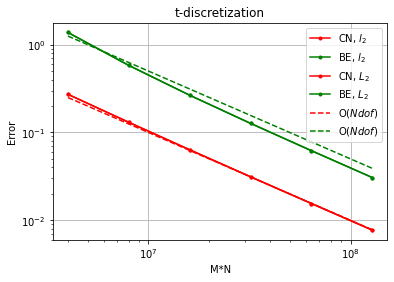

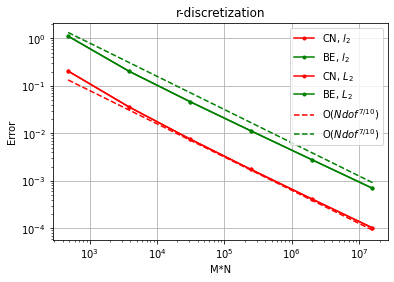

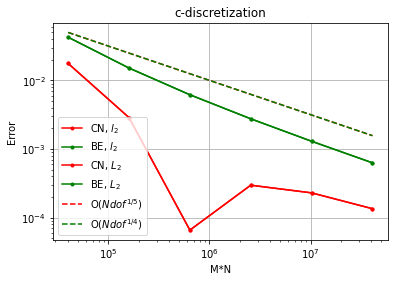

In [11]:
plt.title("h-discretization")
plt.loglog(x_CN_stepNt*x_CN_stepNx,x_CN_l2,".-r",label='CN, $l_2$')
plt.loglog(x_BE_stepNt*x_BE_stepNx,x_BE_l2,".-g",label='BE, $l_2$')
plt.loglog(x_CN_stepNt*x_CN_stepNx,x_CN_L2,".-r",label='CN, $L_2$')
plt.loglog(x_BE_stepNt*x_BE_stepNx,x_BE_L2,".-g",label='BE, $L_2$')
plt.loglog(x_CN_stepNt*x_CN_stepNx, 1e-9*(x_BE_stepNt * 1/x_BE_stepNx)**(2),"--k",label="O($Ndof^{2}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("t-discretization")
plt.loglog(t_CN_stepNt*t_CN_stepNx,t_CN_l2,".-r",label='CN, $l_2$')
plt.loglog(t_BE_stepNt*t_BE_stepNx,t_BE_l2,".-g",label='BE, $l_2$')
plt.loglog(t_CN_stepNt*t_CN_stepNx,t_CN_L2,".-r",label='CN, $L_2$')
plt.loglog(t_BE_stepNt*t_BE_stepNx,t_BE_L2,".-g",label='BE, $L_2$')
plt.loglog(t_CN_stepNt*t_CN_stepNx, 1e-4*(t_CN_stepNx * (1/t_CN_stepNt)),"--r",label="O($Ndof$)")
plt.loglog(t_BE_stepNt*t_BE_stepNx, (1/2000)*(t_BE_stepNx * (1/t_BE_stepNt)),"--g",label="O($Ndof$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("r-discretization")
plt.loglog(r_CN_stepNt*r_CN_stepNx,r_CN_l2,".-r",label='CN, $l_2$')
plt.loglog(r_BE_stepNt*r_BE_stepNx,r_BE_l2,".-g",label='BE, $l_2$')
plt.loglog(r_CN_stepNt*r_CN_stepNx,r_CN_L2,".-r",label='CN, $L_2$')
plt.loglog(r_BE_stepNt*r_BE_stepNx,r_BE_L2,".-g",label='BE, $L_2$')
plt.loglog(r_CN_stepNt*r_CN_stepNx, 1e+1*(1/r_CN_stepNx * 1/r_CN_stepNt)**(7/10),"--r",label="O($Ndof^{7/10}$)")
plt.loglog(r_BE_stepNt*r_BE_stepNx, 1e+2*(1/r_BE_stepNx * 1/r_BE_stepNt)**(7/10),"--g",label="O($Ndof^{7/10}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

plt.title("c-discretization")
plt.loglog(c_CN_stepNt*c_CN_stepNx,c_CN_l2,".-r",label='CN, $l_2$')
plt.loglog(c_CN_stepNt*c_CN_stepNx,c_BE_l2,".-g",label='BE, $l_2$')
plt.loglog(c_CN_stepNt*c_CN_stepNx,c_CN_L2,".-r",label='CN, $L_2$')
plt.loglog(c_CN_stepNt*c_CN_stepNx,c_BE_L2,".-g",label='BE, $L_2$')
plt.loglog(c_CN_stepNt*c_CN_stepNx, 1e1*((1/c_CN_stepNt) * (1/c_CN_stepNx))**(1/2),"--r",label="O($Ndof^{1/5}$)")
plt.loglog(c_BE_stepNt*c_BE_stepNx, 1e+1*((1/c_BE_stepNt) * (1/c_BE_stepNx))**(1/2),"--g",label="O($Ndof^{1/4}$)")
plt.xlabel("M*N")
plt.ylabel("Error")
plt.grid()
plt.legend()
plt.show()

In [12]:
print(x_CN_L2-x_CN_l2)

[-8.68047629e-05 -9.82519377e-06 -4.93239730e-07 -3.21405154e-08
 -2.38412260e-09 -1.27105801e-10]
